In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 3
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
optimizer_type = 'adam'

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, 
                ztf_elt=ztf_elt, 
                site_name=site_name, 
                thresh_deg=thresh_deg,
                optimizer_type=optimizer_type,
                learning_rate=learning_rate, 
                clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_small_{random_seed:04d}.h5',
                name='model')

In [31]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.90  :   0.00 :  1799.79 :  7200.00
Mean     :     0.90  :   0.00 :  1799.79 :  7200.00
Median   :     0.57  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.36  :   0.00 :  1799.78 :  7200.99
Min      :    -1.55  :   0.00 :  1792.82 :  7200.00
Max      :     6.06  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [32]:
# model.load()

In [33]:
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.90  :   0.00 :  1799.79 :  7200.00
Mean     :     0.90  :   0.00 :  1799.79 :  7200.00
Median   :     0.57  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.36  :   0.00 :  1799.78 :  7200.99
Min      :    -1.55  :   0.00 :  1792.82 :  7200.00
Max      :     6.06  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


In [34]:
raise ValueError

ValueError: 

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 3s 674us/sample - loss: -155871.6589
Epoch 2/4
4096/4096 [==============================] - 1s 322us/sample - loss: -252476.0840
Epoch 3/4
4096/4096 [==============================] - 1s 322us/sample - loss: -410478.5532
Epoch 4/4
4096/4096 [==============================] - 1s 326us/sample - loss: -687598.2500
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1531.36 :  1531.36 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      4.43 :     4.43 :      nan
Mean Hits           :      

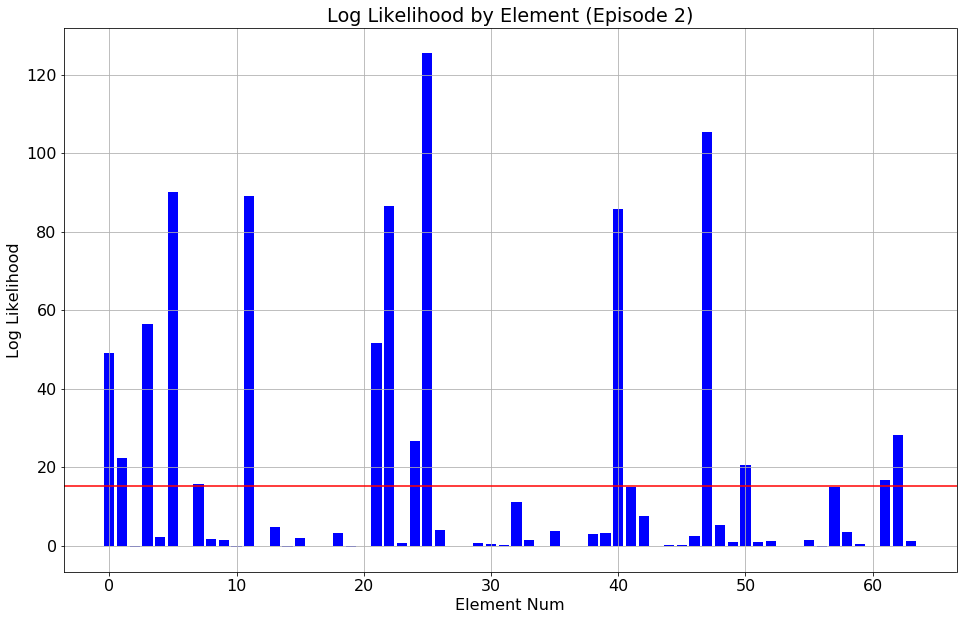

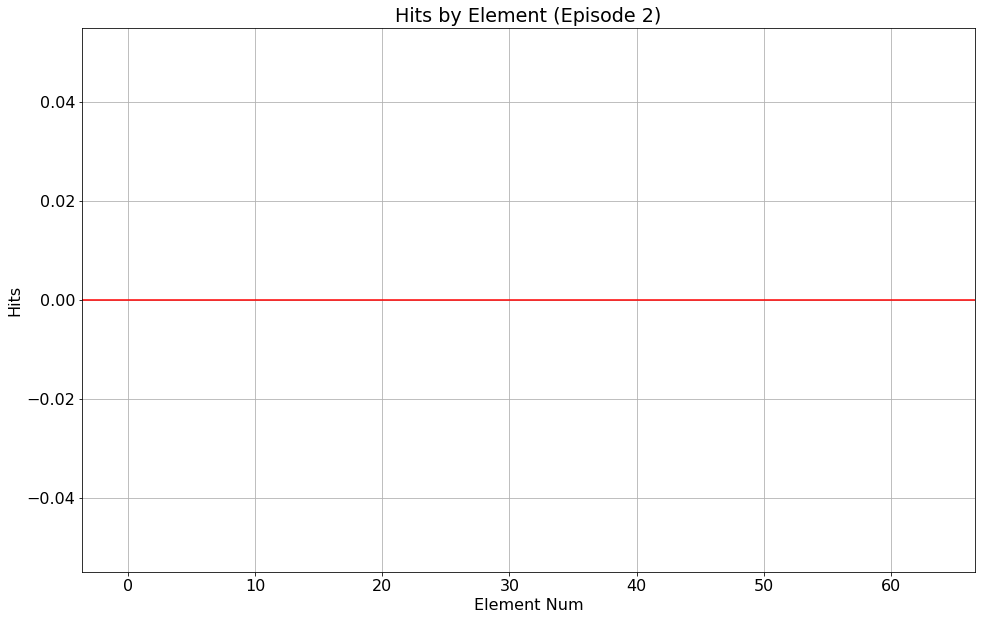


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.441e-04, training_time 25 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 3s 826us/sample - loss: -2038.4325
Epoch 10/12
4096/4096 [==============================] - 2s 430us/sample - loss: -2284.2782
Epoch 11/12
4096/4096 [==============================] - 2s 438us/sample - loss: -2353.1681
Epoch 12/12
4096/4096 [==============================] - 2s 431us/sample - loss: -2403.4241
                    \  All Elts : Bad Elts : Good Elts (4)
Geom Mean Resolution:   1226.72 :  1321.85 :   400.14 arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :  7200.00 arc seconds
Mean Log Likelihood :     37.92 :    31

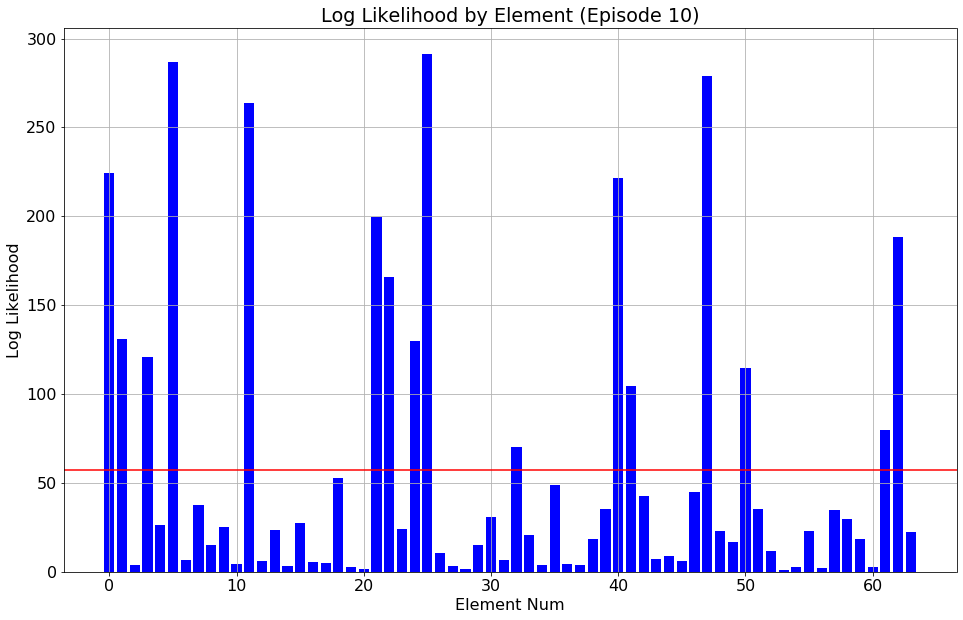

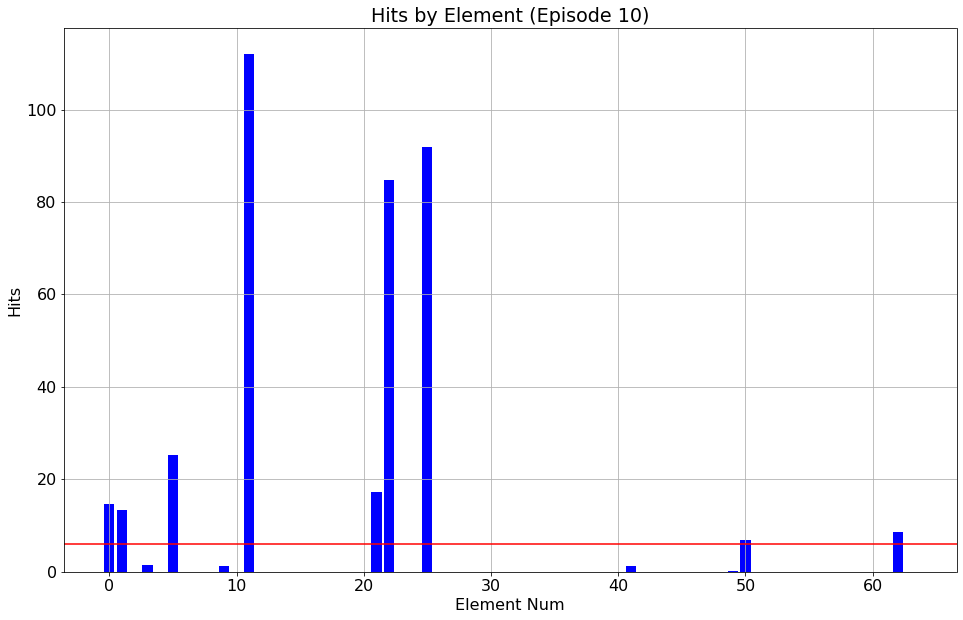


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 94 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 3s 636us/sample - loss: -20990704.9375
Epoch 42/44
4096/4096 [==============================] - 1s 351us/sample - loss: -26057997.9375
Epoch 43/44
4096/4096 [==============================] - 1s 340us/sample - loss: -32277110.7188
Epoch 44/44
4096/4096 [==============================] - 1s 344us/sample - loss: -40290380.0000
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    553.96 :   660.81 :   188.51 arc seconds
Geom Mean Threshold :   5361.01 :  5385.89 :  5211.4

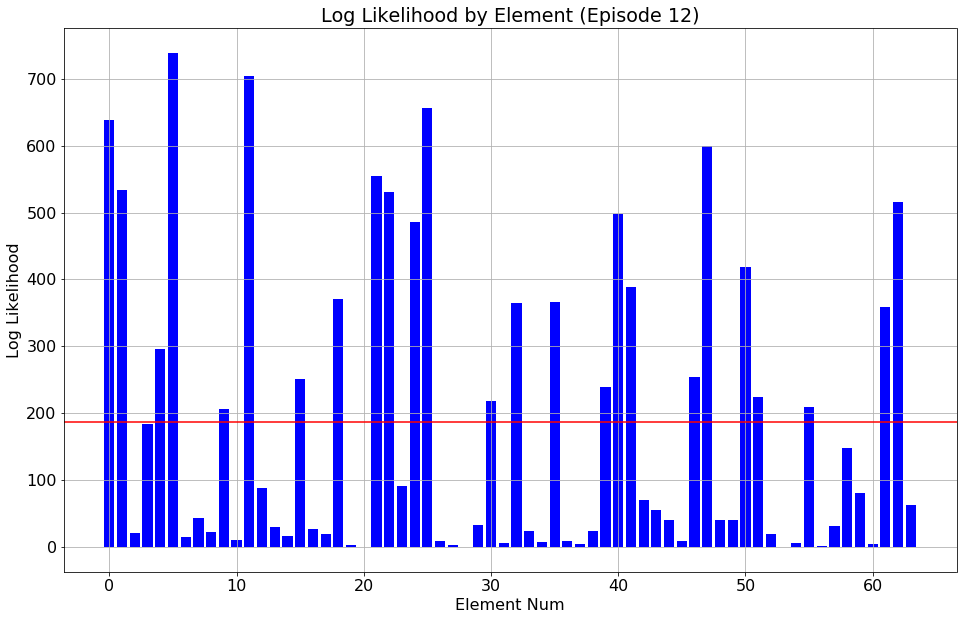

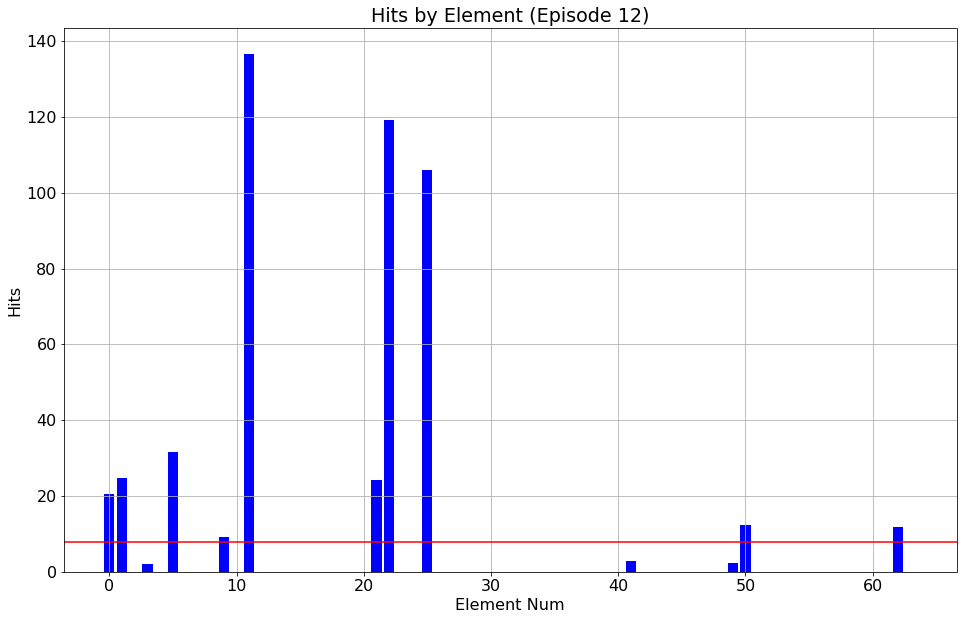


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=2.394e-04, training_time 109 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 3s 844us/sample - loss: -12625.1572
Epoch 50/52
4096/4096 [==============================] - 2s 454us/sample - loss: -13044.7998
Epoch 51/52
4096/4096 [==============================] - 2s 460us/sample - loss: -13217.1648
Epoch 52/52
4096/4096 [==============================] - 2s 447us/sample - loss: -13362.5008
                    \  All Elts : Bad Elts : Good Elts (17)
Geom Mean Resolution:    324.04 :   459.81 :   123.14 arc seconds
Geom Mean Threshold :   4967.75 :  5343.40 :  4060.99 arc seconds
Mean Log Likelihood :    210.25

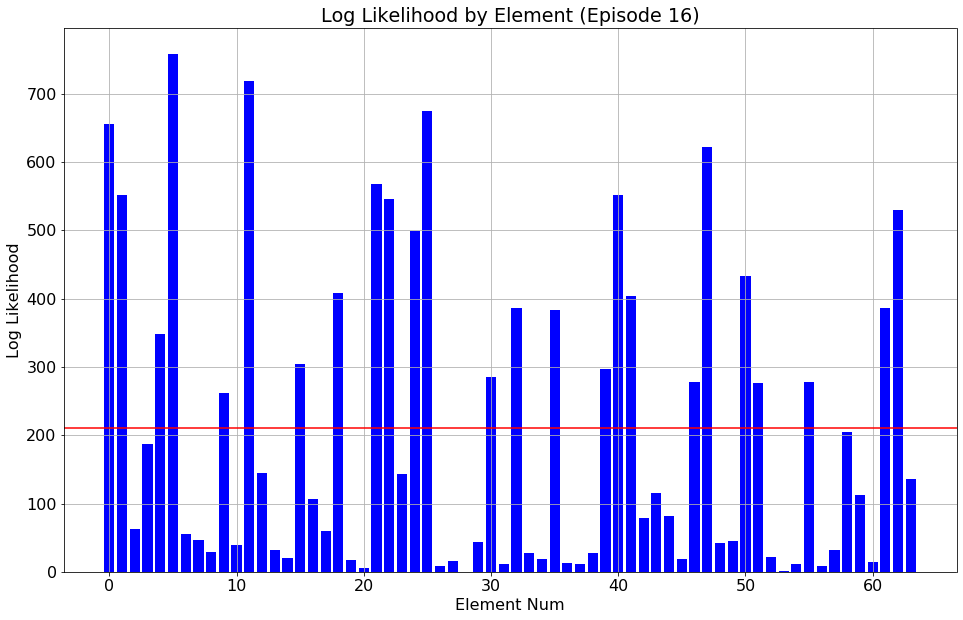

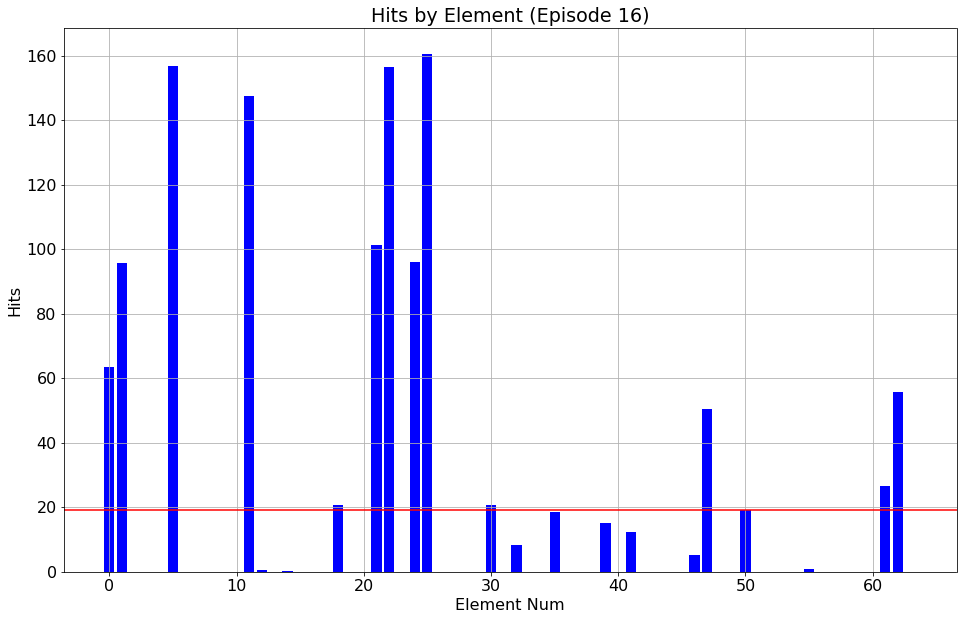


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 16: Epoch   64, Batch   4096
effective_learning_rate=2.441e-04, training_time 146 sec.
Train on 4096 samples
Epoch 65/68
4096/4096 [==============================] - 3s 660us/sample - loss: -153390538.2500
Epoch 66/68
4096/4096 [==============================] - 1s 359us/sample - loss: -178552724.5000
Epoch 67/68
4096/4096 [==============================] - 1s 365us/sample - loss: -207492250.0000
Epoch 68/68
4096/4096 [==============================] - 1s 360us/sample - loss: -240821903.7500
Adjusted element weight down on 3 candidate elements. Mean weight = 9.77e-01
                    \  All Elts : Bad Elts : Good Elts (17)
Geom Mean Resolution:    211.11 :   307.45 :    74.66 arc seconds
Geom Mean Threshold :   3114.79 :  3522.32 :  

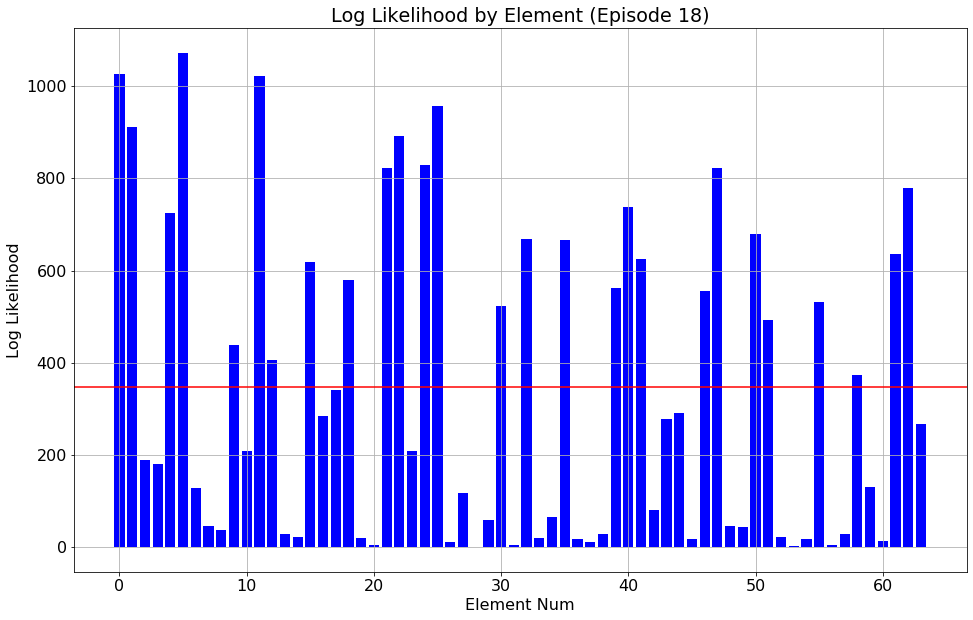

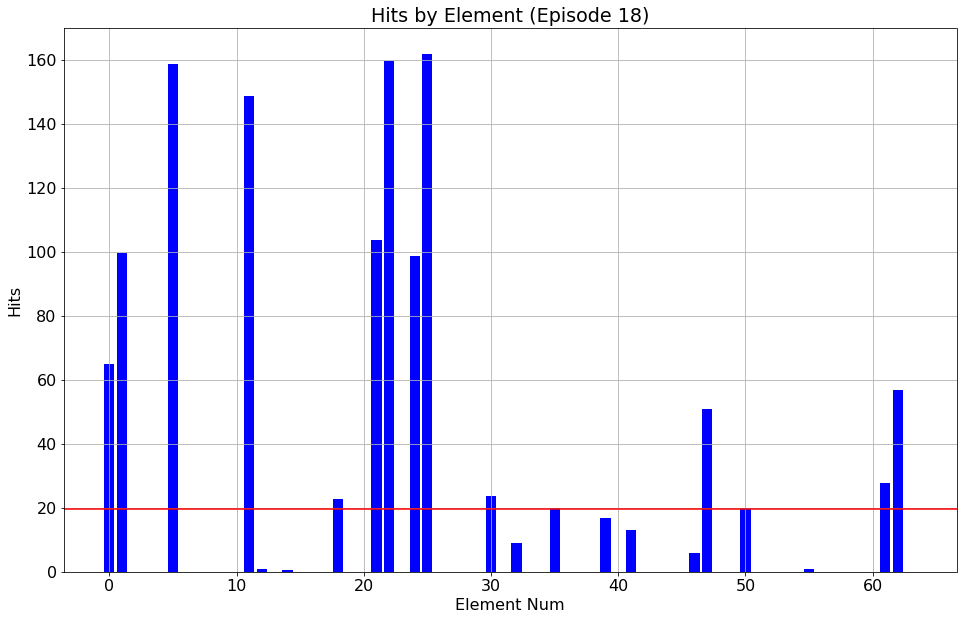


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 18: Epoch   72, Batch   4608
effective_learning_rate=2.260e-04, training_time 162 sec.
Train on 4096 samples
Epoch 73/76
4096/4096 [==============================] - 4s 870us/sample - loss: -21733.0941
Epoch 74/76
4096/4096 [==============================] - 2s 470us/sample - loss: -22748.1653
Epoch 75/76
4096/4096 [==============================] - 2s 476us/sample - loss: -23099.3471
Epoch 76/76
4096/4096 [==============================] - 2s 473us/sample - loss: -23437.2957
                    \  All Elts : Bad Elts : Good Elts (24)
Geom Mean Resolution:    145.48 :   266.92 :    52.90 arc seconds
Geom Mean Threshold :   2595.45 :  3412.73 :  1644.62 arc seconds
Mean Log Likelihood :    371.21

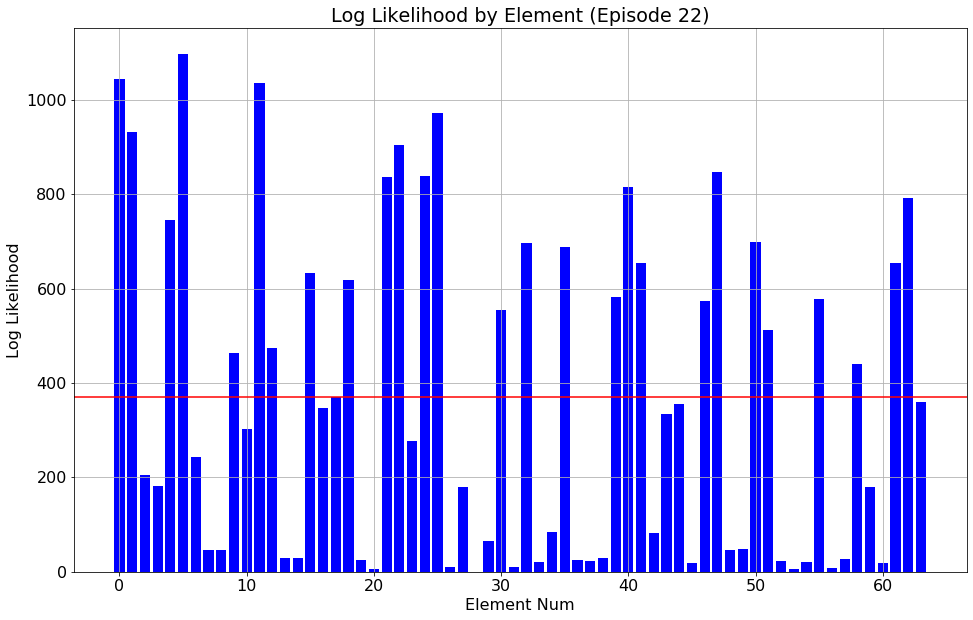

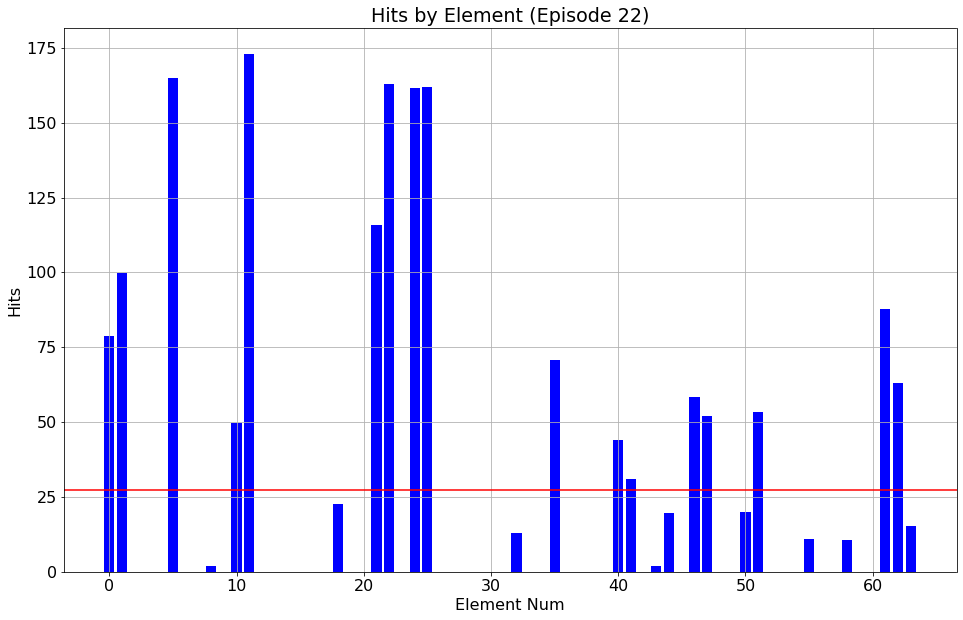


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 22: Epoch   88, Batch   5632
effective_learning_rate=2.441e-04, training_time 201 sec.
Train on 4096 samples
Epoch 89/92
4096/4096 [==============================] - 3s 679us/sample - loss: -503844361.0000
Epoch 90/92
4096/4096 [==============================] - 2s 388us/sample - loss: -549470560.5000
Epoch 91/92
4096/4096 [==============================] - 2s 388us/sample - loss: -597208272.0000
Epoch 92/92
4096/4096 [==============================] - 2s 390us/sample - loss: -646277477.0000
Adjusted element weight down on 5 candidate elements. Mean weight = 9.61e-01
                    \  All Elts : Bad Elts : Good Elts (24)
Geom Mean Resolution:    103.58 :   203.21 :    33.69 arc seconds
Geom Mean Threshold :   1721.44 :  2243.91 :  

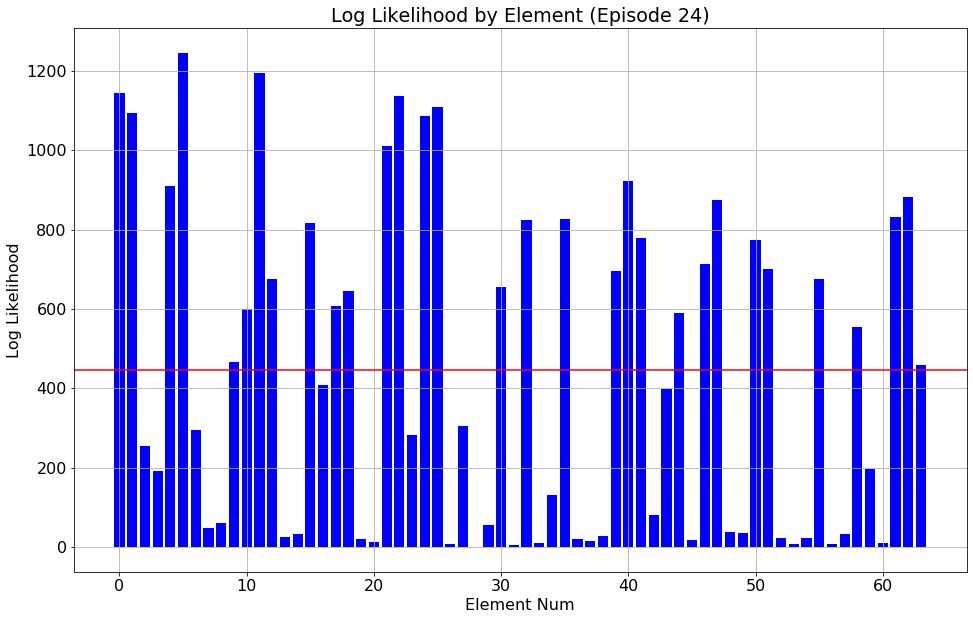

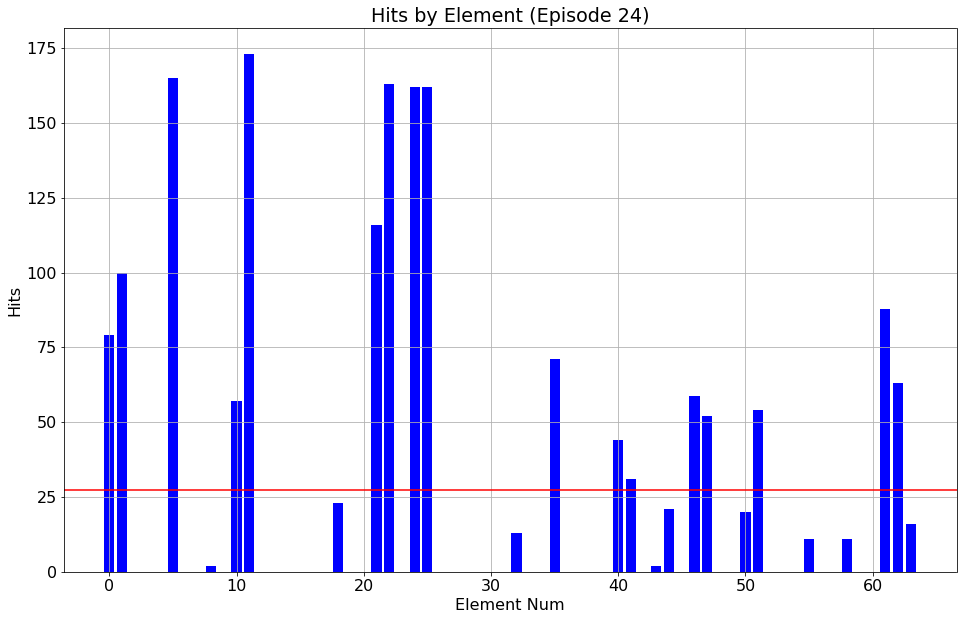


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 24: Epoch   96, Batch   6144
effective_learning_rate=2.069e-04, training_time 218 sec.
Train on 4096 samples
Epoch 97/100
4096/4096 [==============================] - 4s 888us/sample - loss: inf
Adjusted element weight down on 12 candidate elements. Mean weight = 1.42e-02
                    \  All Elts : Bad Elts : Good Elts (24)
Geom Mean Resolution:     80.75 :   175.23 :    22.20 arc seconds
Geom Mean Threshold :   1467.98 :  2088.06 :   815.99 arc seconds
Mean Log Likelihood :    451.98 :   202.00 :   868.63
Mean Hits           :     27.78 :     0.24 :    73.66
Good Elements       :     24.00

Training episode 25: Epoch   97, Batch   6208
effective_learning_rate=2.161e-07, training_time 223

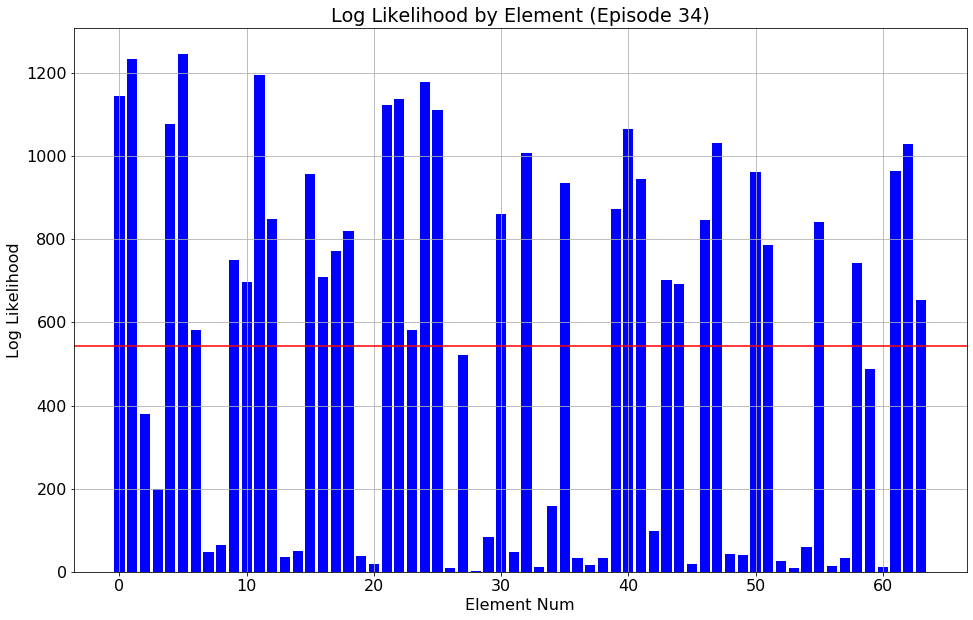

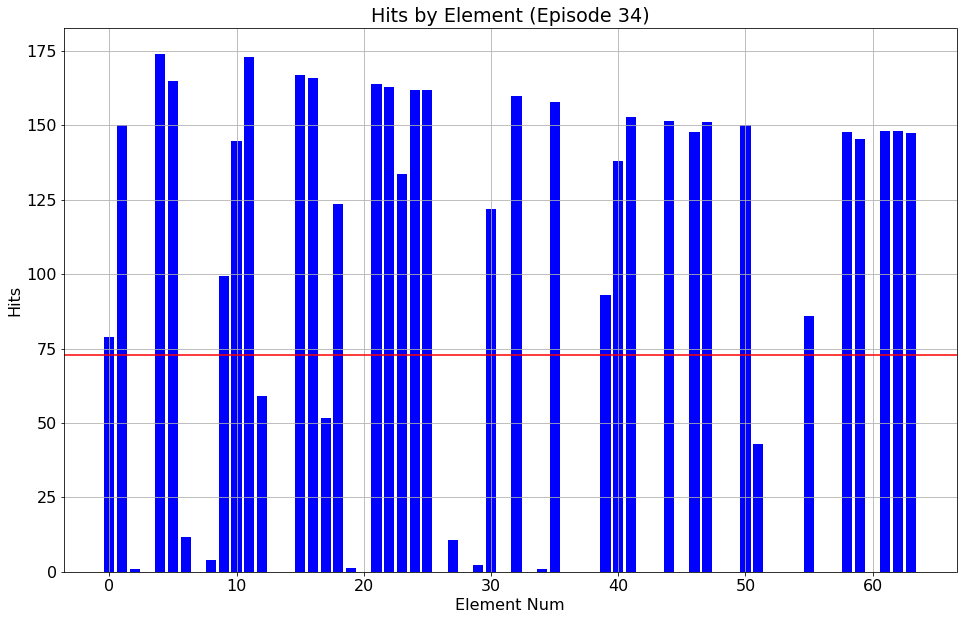


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 34: Epoch  128, Batch   8192
effective_learning_rate=1.221e-04, training_time 301 sec.
Train on 4096 samples
Epoch 129/132
4096/4096 [==============================] - 3s 715us/sample - loss: -28915098877952.0000
Epoch 130/132
4096/4096 [==============================] - 2s 440us/sample - loss: -30565812666368.0000
Epoch 131/132
4096/4096 [==============================] - 2s 438us/sample - loss: -32305992794112.0000
Epoch 132/132
4096/4096 [==============================] - 2s 432us/sample - loss: -34131054395392.0000
Adjusted element weight down on 17 candidate elements. Mean weight = 8.67e-01
                    \  All Elts : Bad Elts : Good Elts (36)
Geom Mean Resolution:     58.41 :   213

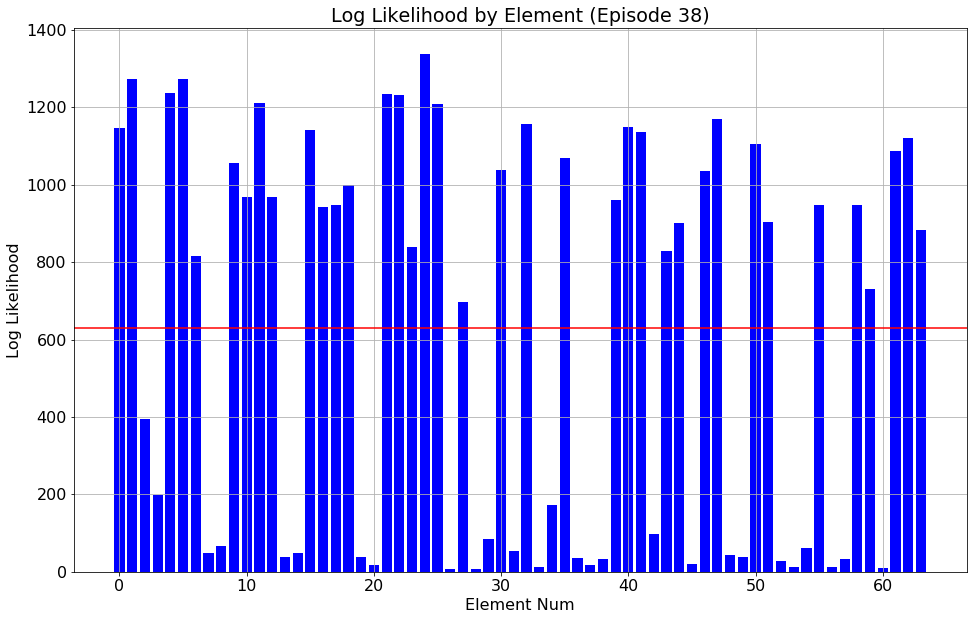

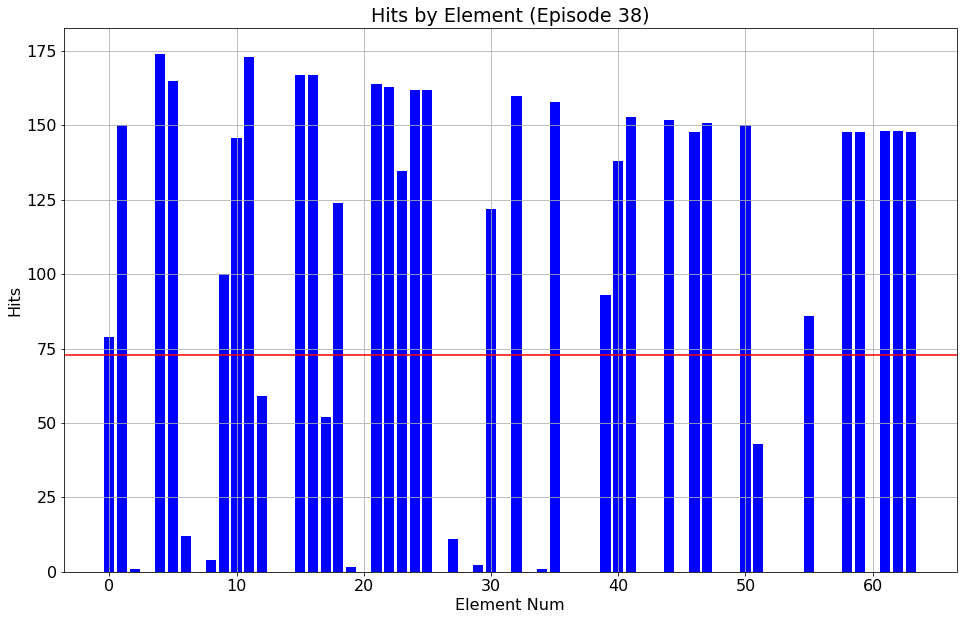


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 38: Epoch  144, Batch   9216
effective_learning_rate=3.815e-06, training_time 334 sec.
Train on 4096 samples
Epoch 145/148
4096/4096 [==============================] - 4s 978us/sample - loss: -1075011751.0000
Epoch 146/148
4096/4096 [==============================] - 2s 560us/sample - loss: -1130979014.0000
Epoch 147/148
4096/4096 [==============================] - 2s 565us/sample - loss: -1135179226.0000
Epoch 148/148
4096/4096 [==============================] - 2s 559us/sample - loss: -1138577018.0000
Adjusted element weight down on 11 candidate elements. Mean weight = 9.14e-01
                    \  All Elts : Bad Elts : Good Elts (37)
Geom Mean Resolution:     37.93 :   206.24 :    11.02 arc

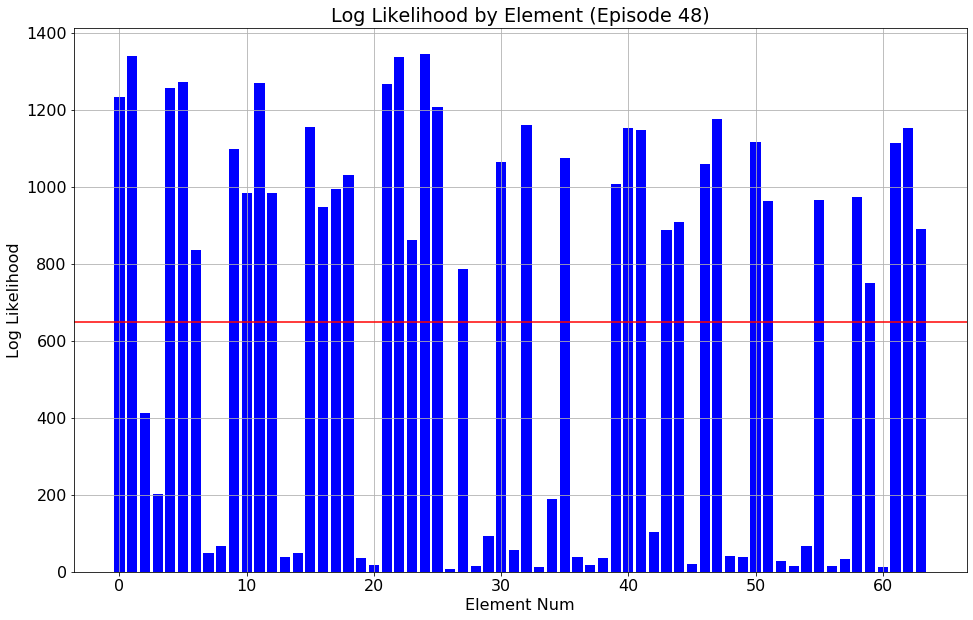

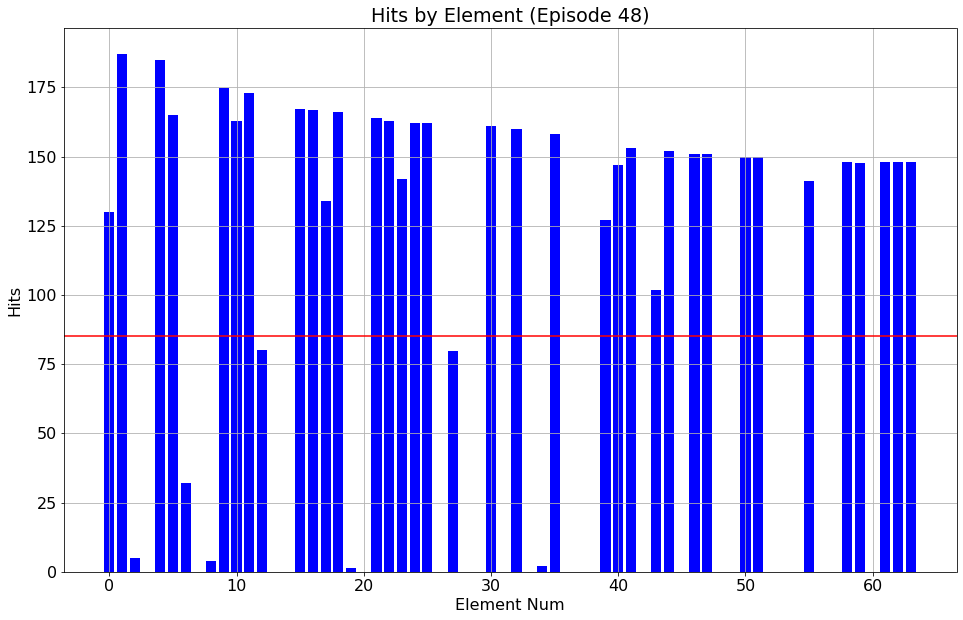


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 48: Epoch  179, Batch  11456
effective_learning_rate=3.815e-06, training_time 434 sec.
Train on 4096 samples
Epoch 180/183
4096/4096 [==============================] - 5s 1ms/sample - loss: -42935274659840.0000
Epoch 181/183
4096/4096 [==============================] - 3s 622us/sample - loss: -45324334137344.0000
Epoch 182/183
4096/4096 [==============================] - 3s 625us/sample - loss: -45532290154496.0000
Epoch 183/183
4096/4096 [==============================] - 3s 636us/sample - loss: -45692570304512.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
                    \  All Elts : Bad Elts : Good Elts (37)
Geom Mean Resolution:     36.50 :   202.79 :

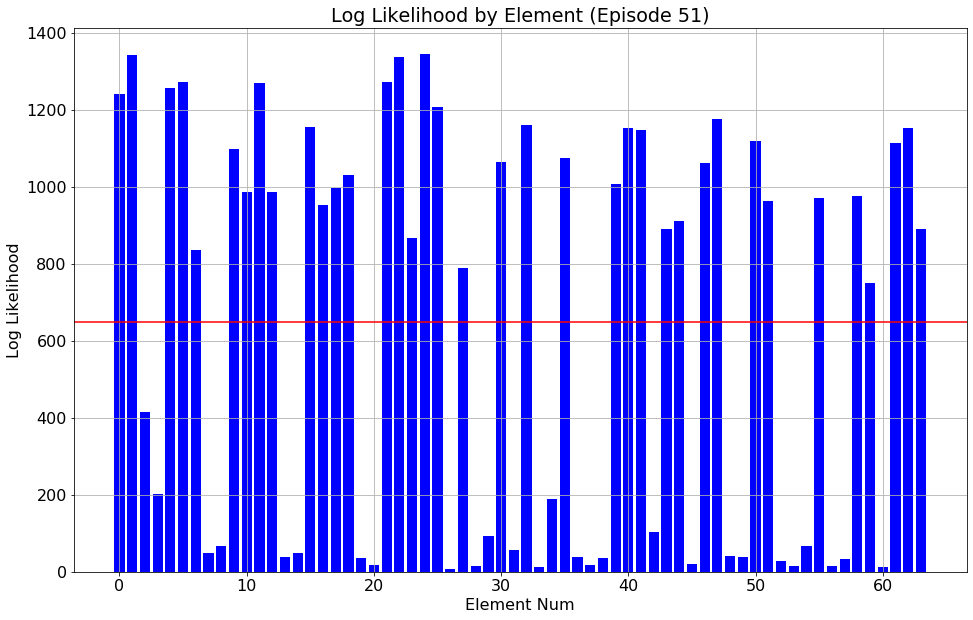

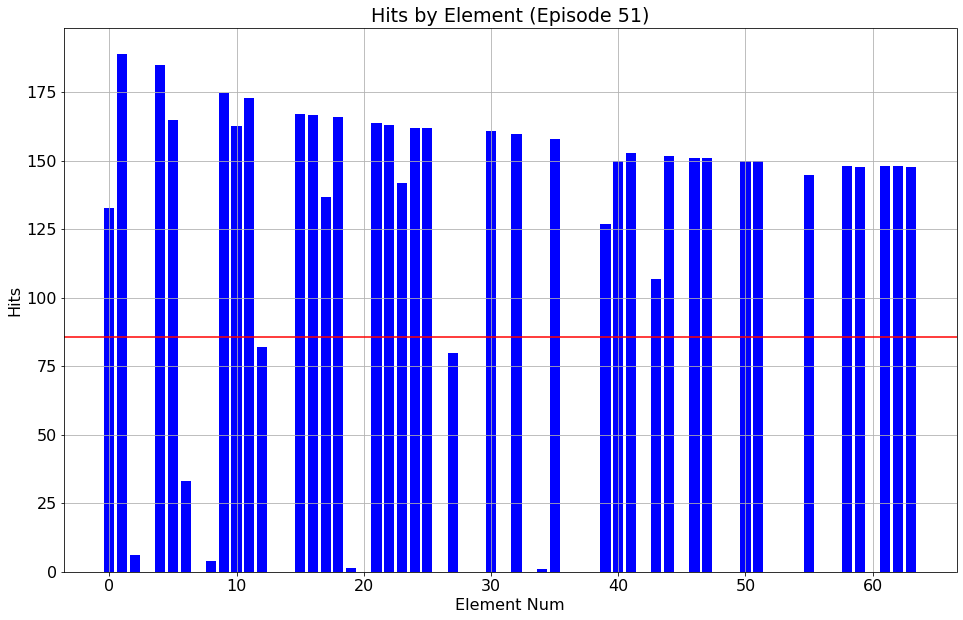

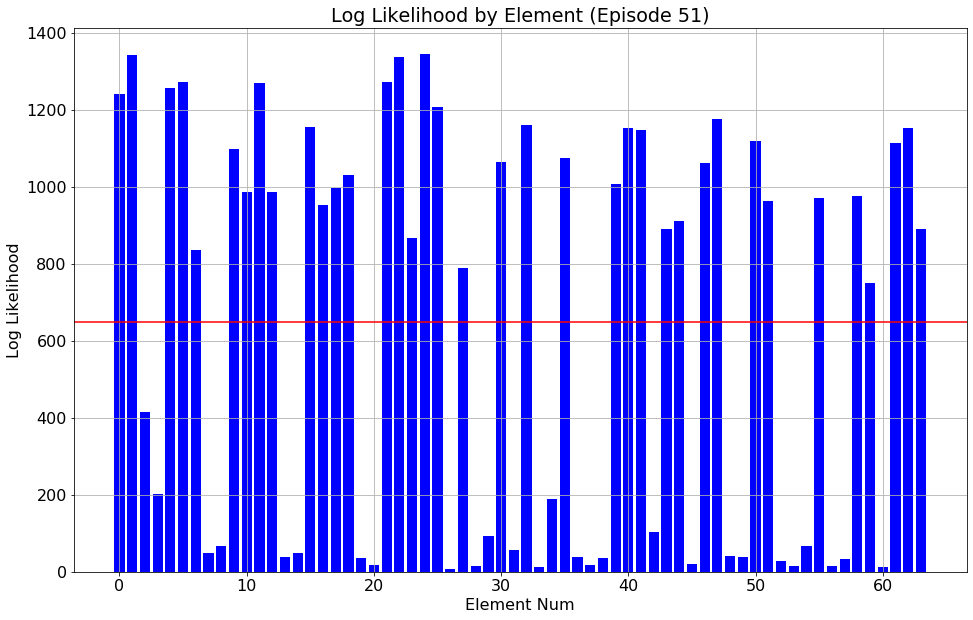

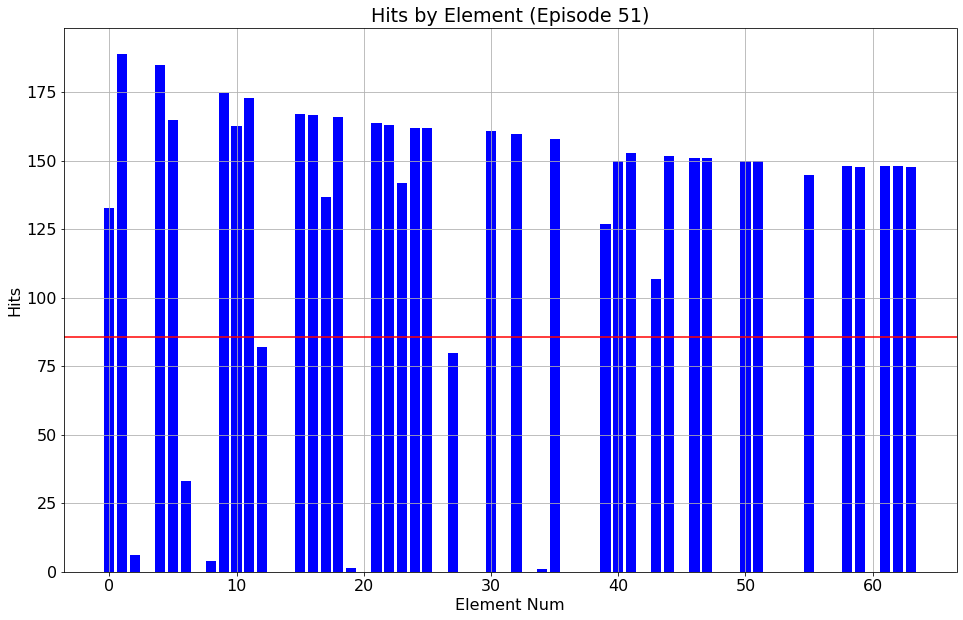

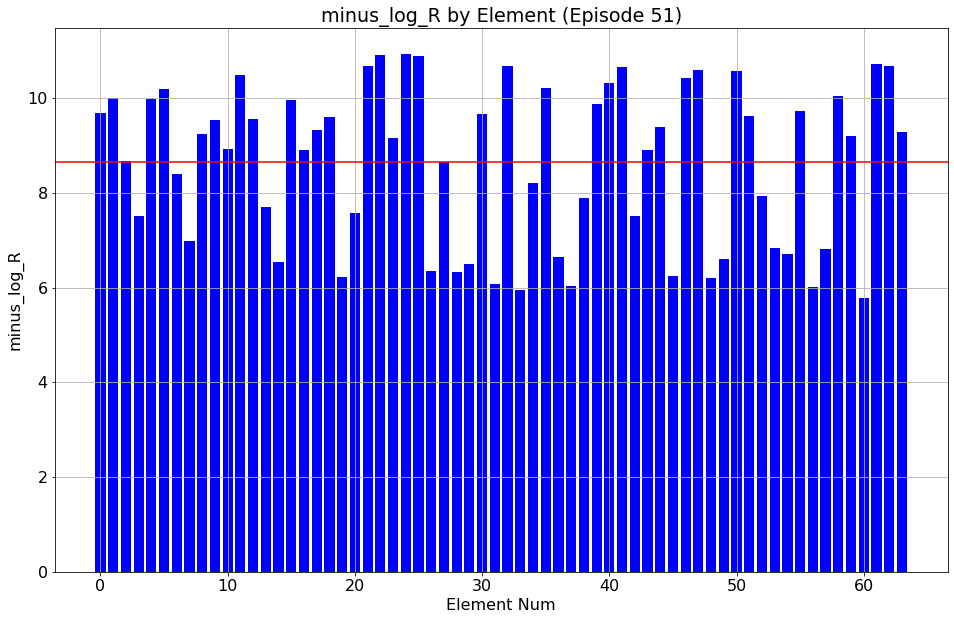

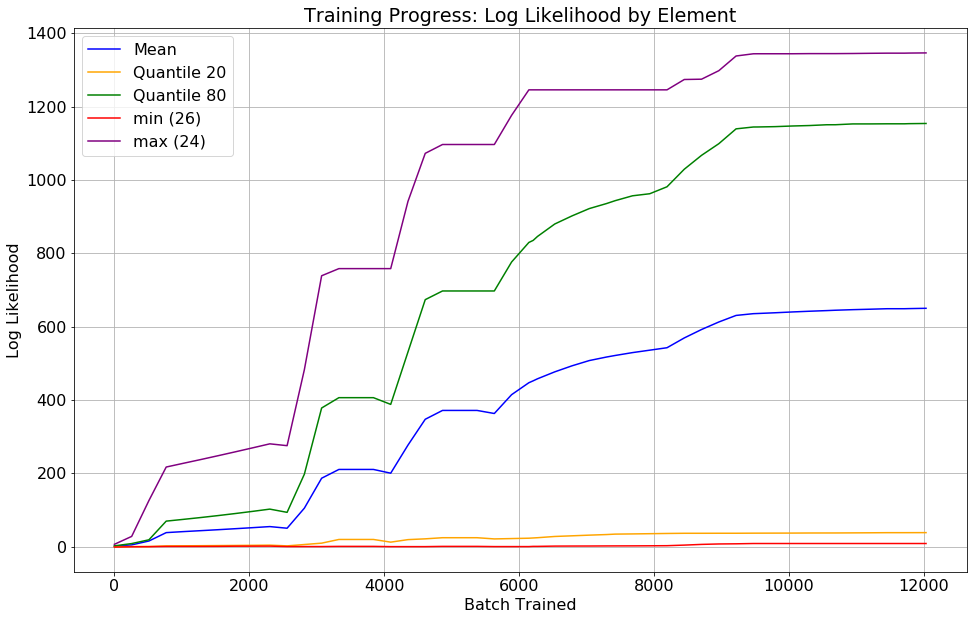

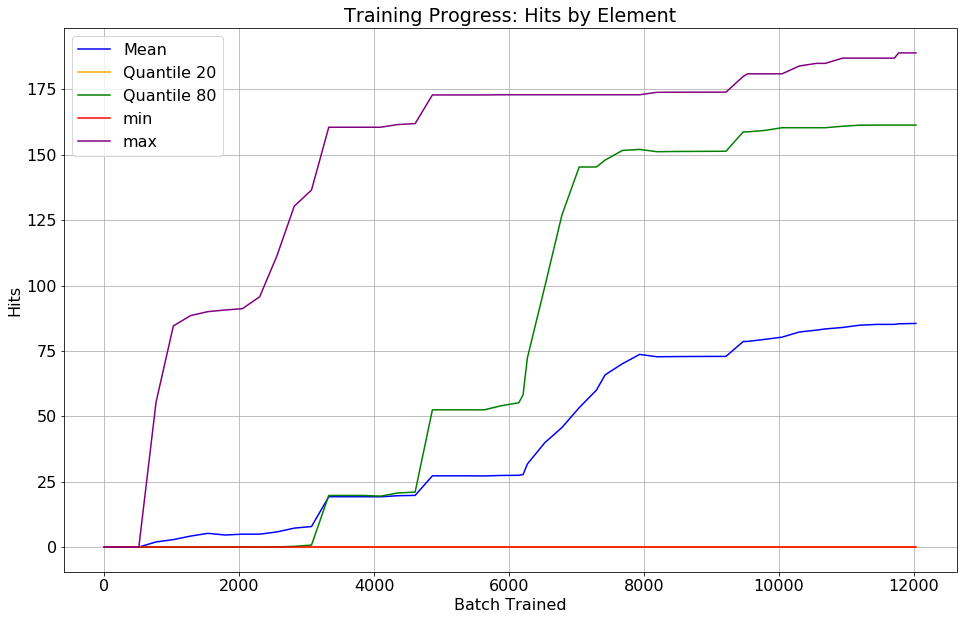

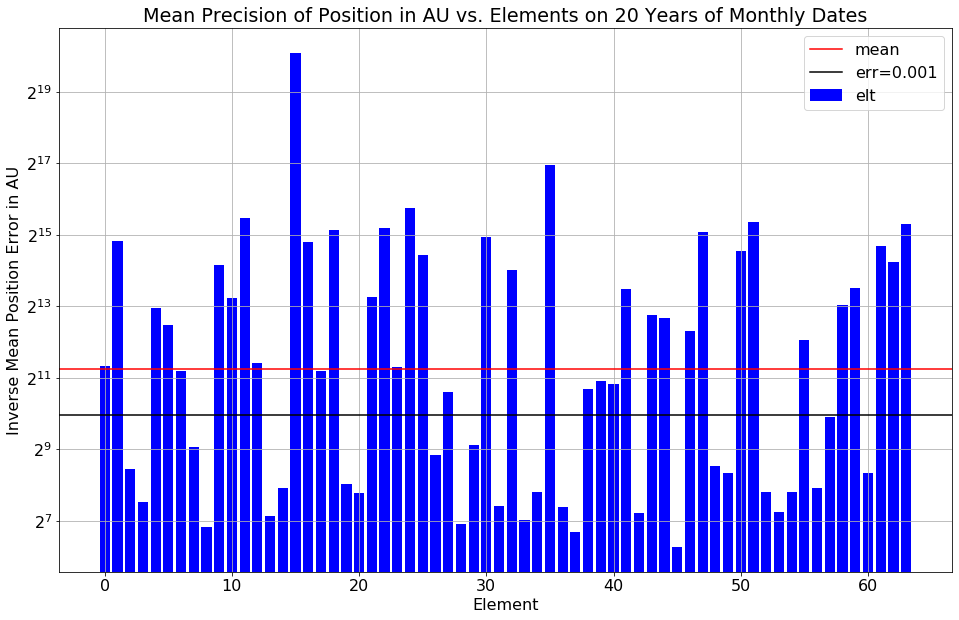

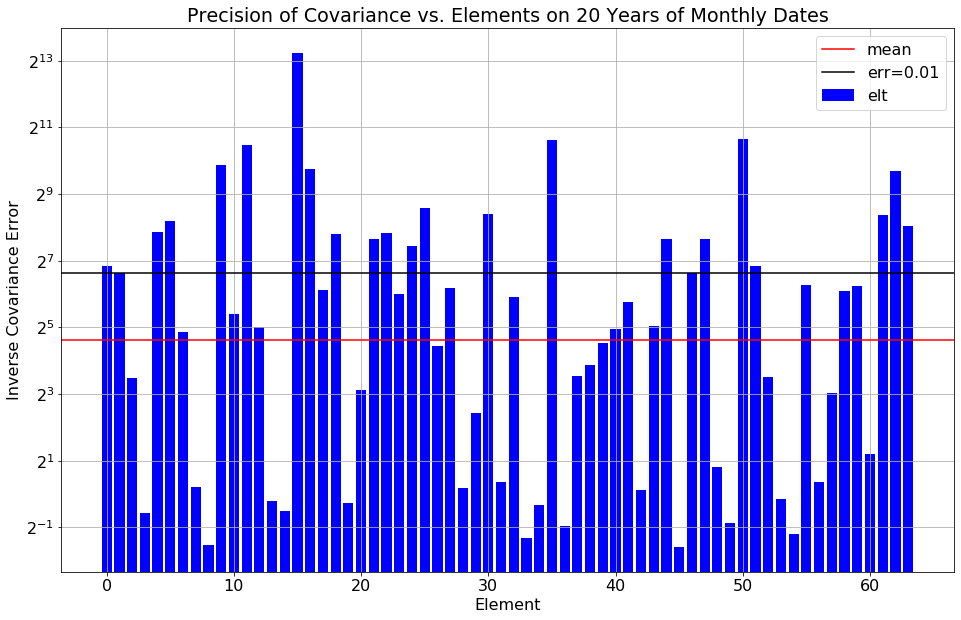

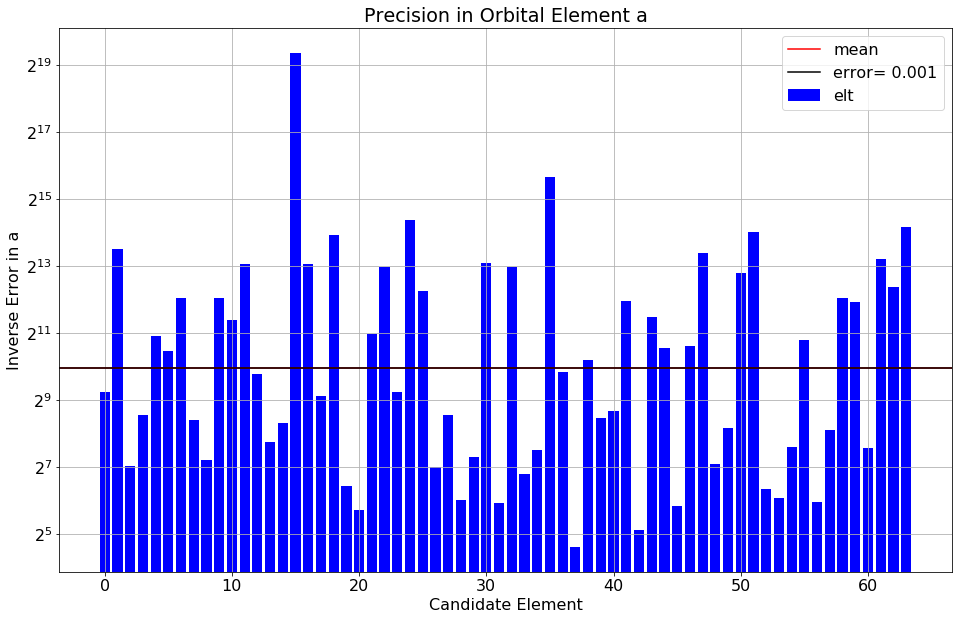

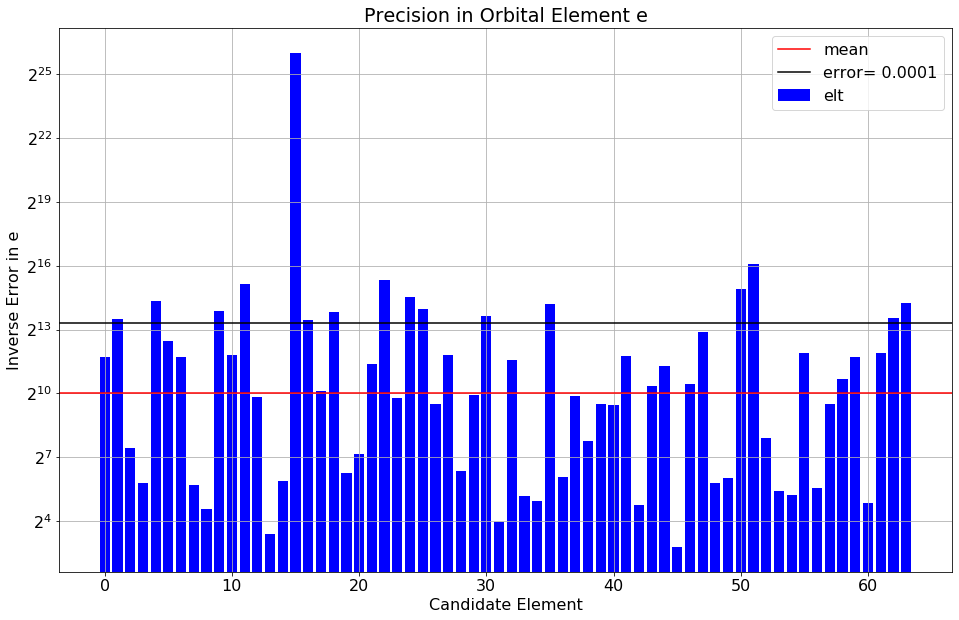

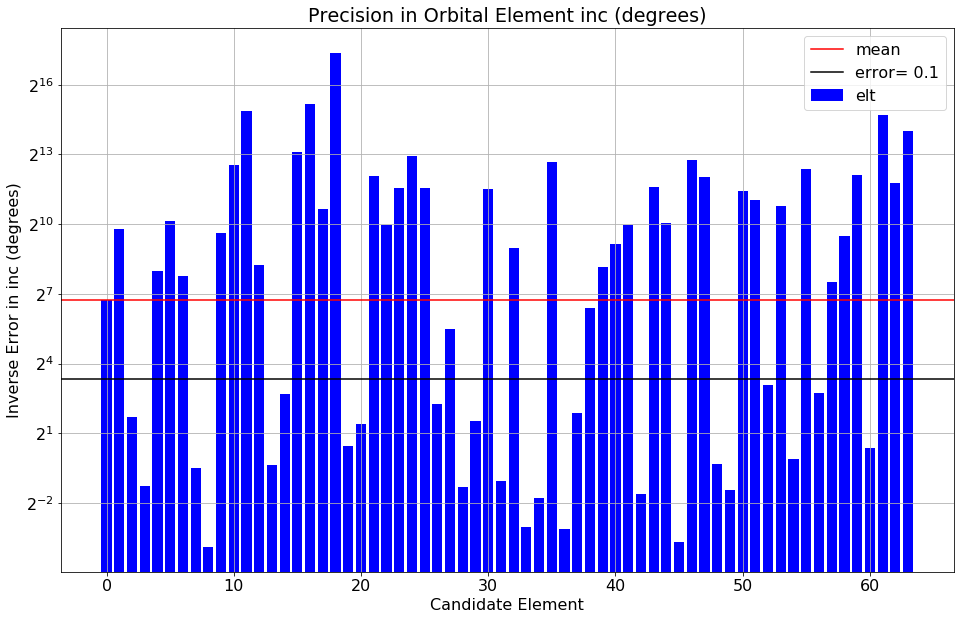

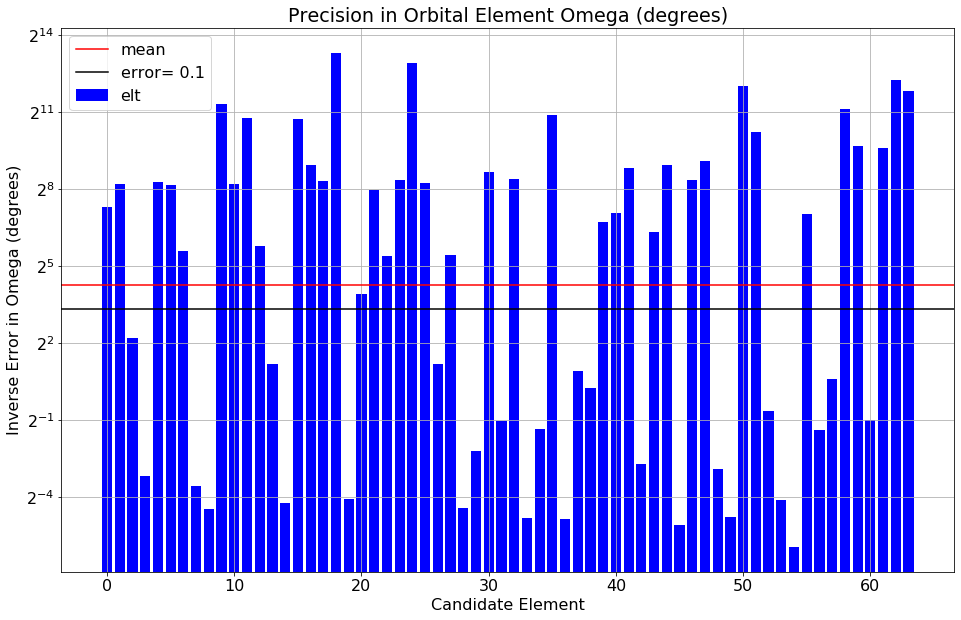

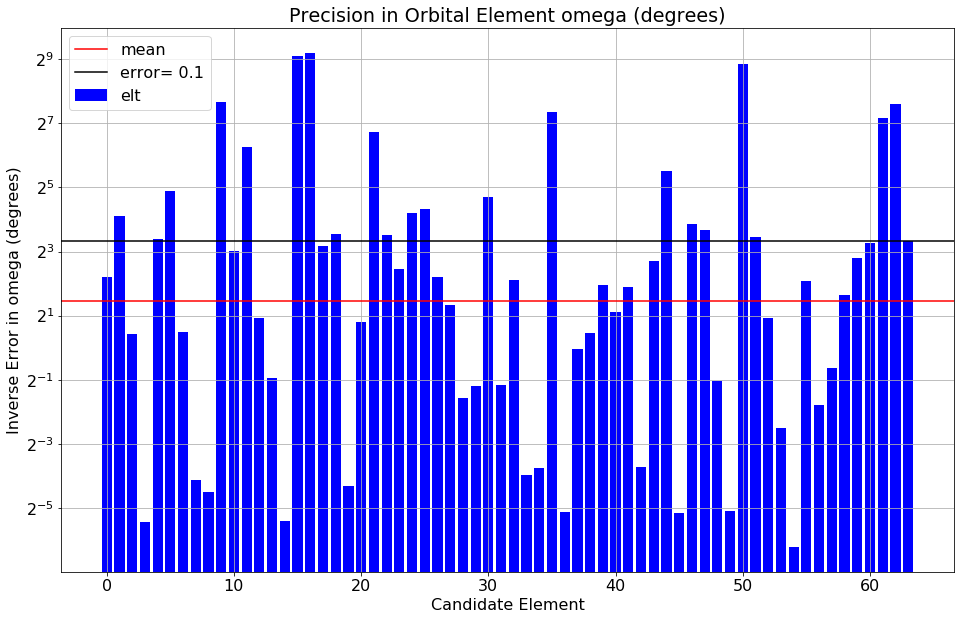

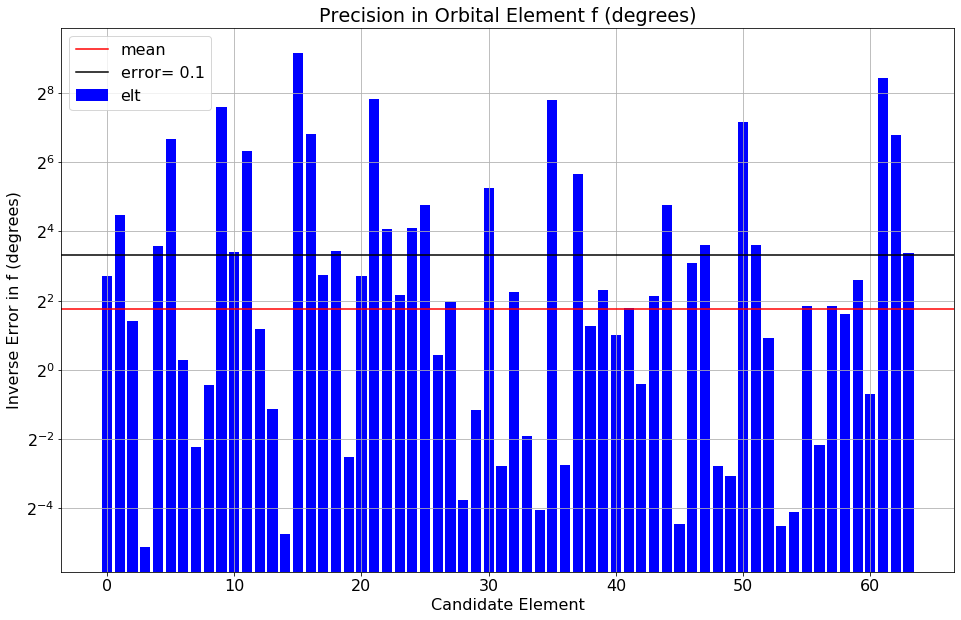

In [35]:
model.sieve()

In [36]:
model.report()


Good elements (hits >= 10):  37.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1077.57  : 147.65 :    13.17 :   593.59
Mean Bad :    63.60  :   0.44 :   271.97 :  2297.75
Mean     :   649.80  :  85.55 :   122.35 :  1312.53
Median   :   891.50  : 130.00 :    21.36 :   936.13
GeoMean  :   262.28  :  18.10 :    37.81 :  1003.29
Min      :     8.22  :   0.00 :     3.70 :   244.07
Max      :  1346.41  : 189.00 :   635.53 :  2400.00
Trained for 12032 batches over 188 epochs and 51 episodes (elapsed time 466 seconds).


In [39]:
base_size = 64

# Episode sizes
num_batches_mixture = base_size * 8 # 512
num_batches_joint = base_size * 32  # 2048

# Set batches_per_epoch parameter
batches_per_epoch: int = 64
epochs_per_episode: int = 4

# Set learning rates
learning_rate_mixture = 2.0**-12
learning_rate_joint = 2.0**-16

# Minimum learning rate
min_learning_rate_mixture = 2.0**-20
min_learning_rate_joint = 2.0**-24

In [43]:
self = model
schedule_len = 5


********************************************************************************
Round 14: 512 batches @ LR 2^-12 in mixture mode.
********************************************************************************

Training episode 51: Epoch  188, Batch  12032
effective_learning_rate=2.441e-04, training_time 466 sec.
Train on 4096 samples
Epoch 189/192
4096/4096 [==============================] - 4s 1ms/sample - loss: -2652374817629536256.0000
Epoch 190/192
4096/4096 [==============================] - 2s 549us/sample - loss: -2940866314907942912.0000
Epoch 191/192
4096/4096 [==============================] - 2s 538us/sample - loss: -3246706516534755328.0000
Epoch 192/192
4096/4096 [==============================] - 2s 558us/sample - loss: -3563957608748417024.0000
Adjusted element weight down on 25 candidate elements. Mean weight = 8.05e-01
                    \  All Elts : Bad Elts : Good Elts (37)
Geom Mean Resolution:     27.65 :   188.60 :     6.81 arc seconds
Geom Mean Threshold : 

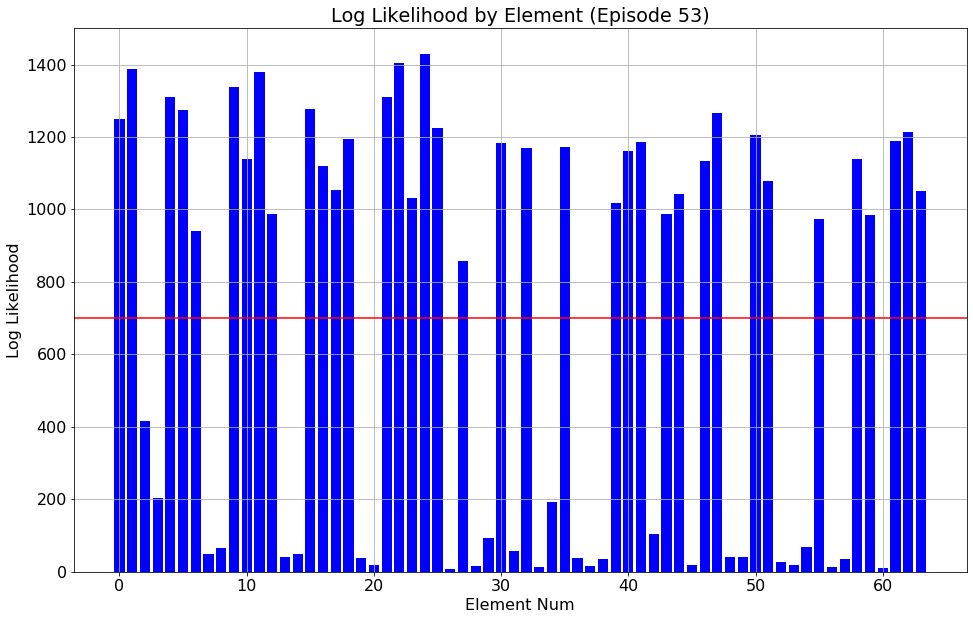

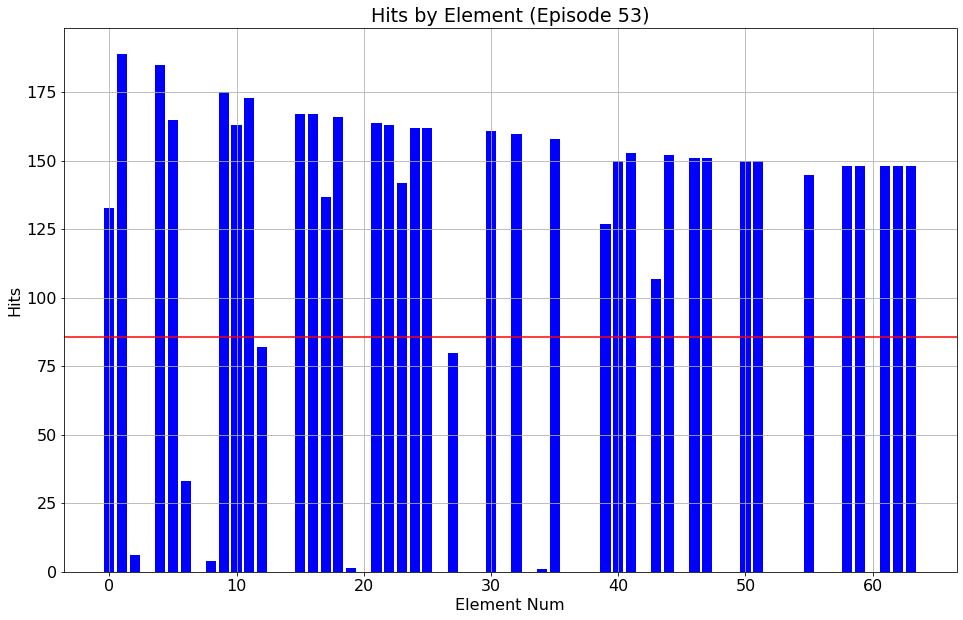

In [44]:
self.sieve_round(round=2*schedule_len+4,
                 num_batches=num_batches_mixture, 
                 batches_per_epoch=batches_per_epoch,
                 epochs_per_episode=epochs_per_episode,
                 training_mode='mixture', 
                 learning_rate=learning_rate_mixture, 
                 min_learning_rate=min_learning_rate_mixture,
                 reset_active_weight=True,
                 obj_den_R_power=3.0,
                 obj_den_thresh_power=3.0)


********************************************************************************
Round 15: 512 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 53: Epoch  196, Batch  12544
effective_learning_rate=1.526e-05, training_time 687 sec.
Train on 4096 samples
Epoch 197/200
4096/4096 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 58 candidate elements. Mean weight = 5.47e-01
                    \  All Elts : Bad Elts : Good Elts (37)
Geom Mean Resolution:     22.03 :   184.82 :     4.67 arc seconds
Geom Mean Threshold :    695.31 :  2145.67 :   305.54 arc seconds
Mean Log Likelihood :    700.00 :    64.22 :  1163.95
Mean Hits           :     85.55 :     0.46 :   147.64
Good Elements       :     37.00

Training episode 54: Epoch  197, Batch  12608
effective_learning_rate=8.345e-06, training_time 785 

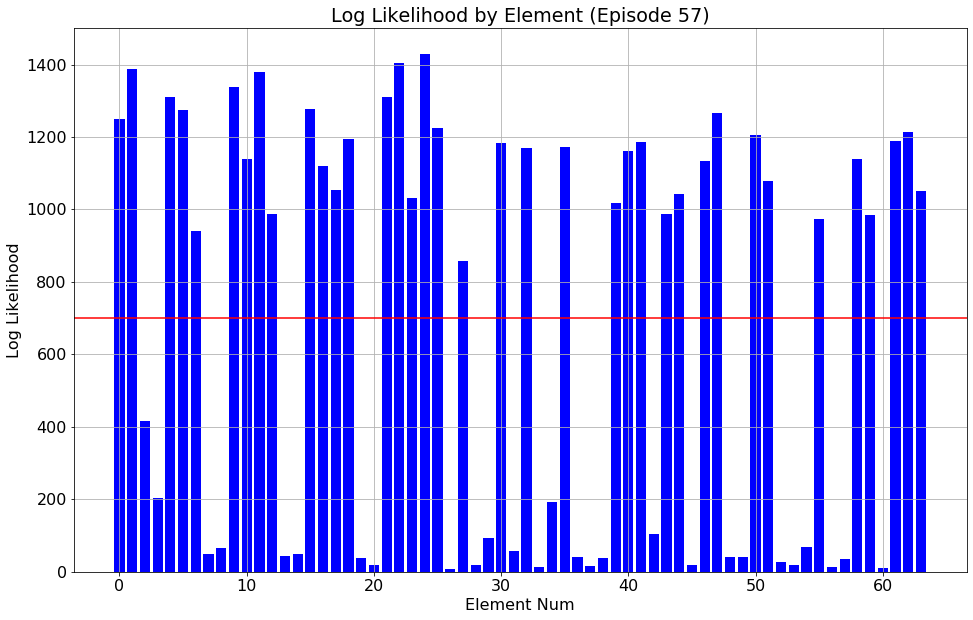

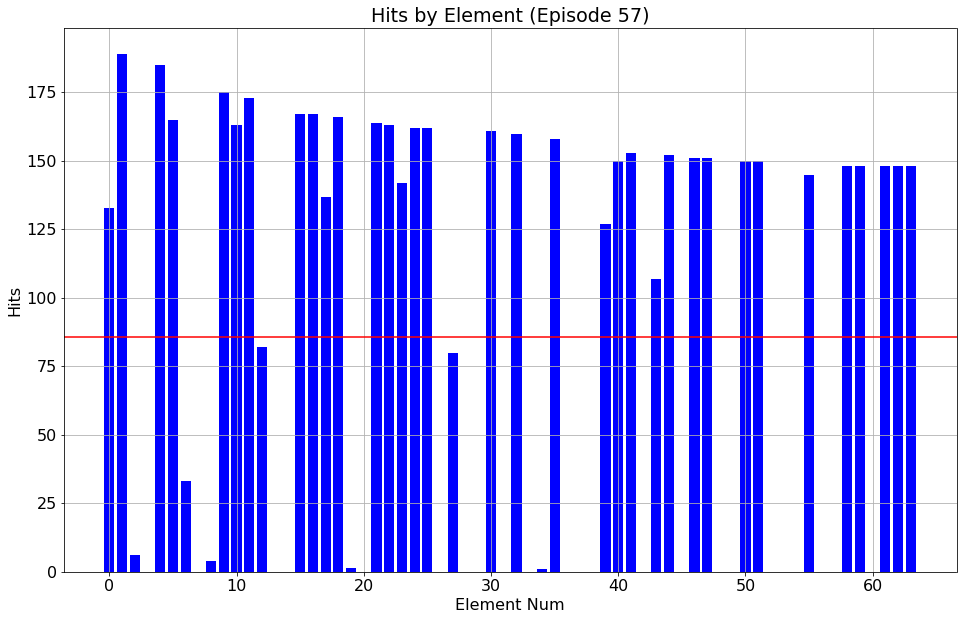

In [46]:
self.sieve_round(round=2*schedule_len+5,
                 num_batches=num_batches_mixture, 
                 batches_per_epoch=batches_per_epoch,
                 epochs_per_episode=epochs_per_episode,
                 training_mode='joint', 
                 learning_rate=learning_rate_joint, 
                 min_learning_rate=min_learning_rate_joint,
                 reset_active_weight=True,
                 obj_den_R_power=3.0,
                 obj_den_thresh_power=3.0)

In [ ]:
fig, ax = model.plot_hist('hits')

In [ ]:
fig, ax = model.plot_hist('log_like')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
model.report()

In [49]:
model.nearest_ast()

(    element_id         a         e       inc     Omega     omega         f  \
 0        51921  2.670941  0.217662  0.499719  4.699593  2.454593 -1.136161   
 1        59244  2.634641  0.262588  0.465025  5.738238  1.768014 -1.602152   
 2        15786  1.875664  0.053517  0.387021  6.130963  0.791825 -1.252561   
 3         3904  2.632015  0.101016  0.262760  5.470125  2.211365 -1.355209   
 4       142999  2.620461  0.191424  0.514087  0.238078  0.944802 -1.297830   
 ..         ...       ...       ...       ...       ...       ...       ...   
 59       11952  2.219903  0.086387  0.117963  0.042421  2.902300 -3.013710   
 60      134815  2.607536  0.175835  0.500269  0.238152  0.647367 -0.986007   
 61       27860  2.619301  0.095924  0.200632  5.541422  3.265925  3.948720   
 62       85937  2.342103  0.197184  0.439058  5.279689  3.210114  3.947529   
 63       72911  3.155515  0.086444  0.262049  5.311931  2.106818 -1.019010   
 
       epoch    num_hits         R  ...  thresh_de

In [ ]:
# model.save_state()

In [47]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 37 asteroids.
Mean on converged asteroids:
Number of hits         : 147.64
Resolution in arc sec  :  5.83
GeoMean Distance in AU : 7.73e-05
Covariance norm        : 5.77e-03


In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [ ]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)